# メモ
- [x] スコアの測定
- [x] オプション： merge_chunks
- [x] 実験環境をローカルへ移す
- [x] NAIST-SICへ適用した際のエラーを修正

# セットアップ

In [1]:
!python -m spacy download en_core_web_md
!pip install benepar
import spacy
import nltk
import benepar
benepar.download('benepar_en3')
from nltk.tree import Tree
import warnings
warnings.simplefilter('ignore')
import re

# Load the English model for spaCy
nlp = spacy.load("en_core_web_md")
nlp.add_pipe('benepar', config={'model': 'benepar_en3'})

2023-11-30 08:51:45.154050: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-30 08:51:45.154114: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-30 08:51:45.154148: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-30 08:51:45.163001: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-30 08:51:46.407338: W tensorflow/compiler/

[nltk_data] Downloading package benepar_en3 to /root/nltk_data...
[nltk_data]   Unzipping models/benepar_en3.zip.
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [146]:
# function for formatting output
def format_chunked_list(splits):
    splits_ = []
    for e in splits:
        if e != "/ " or (splits_ and splits_[-1] != "/ "):
            splits_.append(e)
    # return "".join(splits_)
    return re.sub(r"(?<! )/ ", "", "".join(splits_))

# function for sentence parsing
def parse_tree(sentence):
    doc = nlp(sentence)
    sent = list(doc.sents)[0]
    tree_string = sent._.parse_string

    token_space_mapping = {}
    for i, token in enumerate(doc):
        if token.text not in token_space_mapping.keys():
            token_space_mapping[token.text] = [token.text_with_ws]
        else:
            token_space_mapping[token.text].append(token.text_with_ws)
    return tree_string, token_space_mapping


def replace_special_tags_in_tree(tree):
    """
    Replace special tags in the tree with their original symbols.
    """
    replacements = {
        "-LRB-": "(", "-RRB-": ")",
        "-LSB-": "[", "-RSB-": "]",
        "-LCB-": "{", "-RCB-": "}"
    }

    for pos in range(len(tree)):
        if type(tree[pos]) is Tree:
            replace_special_tags_in_tree(tree[pos])
        elif tree[pos] in replacements:
            tree[pos] = replacements[tree[pos]]
    return tree

# 付録

## Ex: Syntax tree visualization

In [4]:
# virtual display
!pip install pyvirtualdisplay
!pip3 install svgling cairosvg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.1/75.1 kB 10.5 MB/s eta 0:00:00


In [145]:
import os
from nltk.draw.tree import TreeView
import svgling
import cairosvg
from IPython.display import Image,display_png

def visualize_syntax_tree(sentence):
    doc = nlp(sentence)
    sent = list(doc.sents)[0]
    tree_string = sent._.parse_string
    print(tree_string)
    parsed_tree = Tree.fromstring(tree_string)

    # converts any nltk tree object to a svg
    def tree2svg(t):
        img = svgling.draw_tree(t)
        svg_data = img.get_svg()
        return svg_data

    # convert tree to svg
    sv = tree2svg(parsed_tree)
    # write the svg as an image
    cairosvg.svg2png(sv.tostring(), write_to='image.png')

    display_png(Image('image.png'))

(S (NP (PRP You)) (VP (VBD interacted) (PP (IN with) (NP (NP (DT the) (NN company)) (SBAR (SBAR (WHNP (WDT that)) (S (NP (PRP you)) (VP (VBP work) (PP (IN for))))) (CC or) (SBAR (WHNP (WDT that)) (S (NP (PRP you)) (VP (VBP own)))))))) (. .))


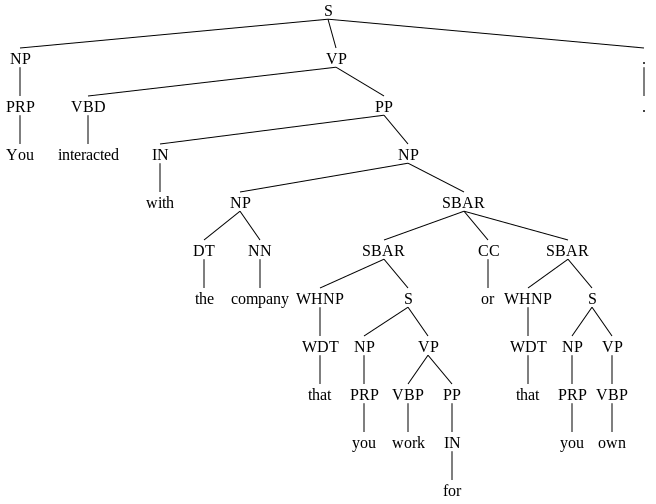

(S (NP (PRP He)) (VP (VBZ knows) (SBAR (S (NP (NP (PRP it))) (VP (VBZ 's) (ADJP (JJ wrong)) (S (VP (TO to) (VP (VP (VB jump) (ADVP (RB up))) (CC and) (VP (VB risk) (S (VP (VBG ruining) (NP (PDT all) (DT this) (JJ beautiful) (NN tableware)))))))))))) (. .))


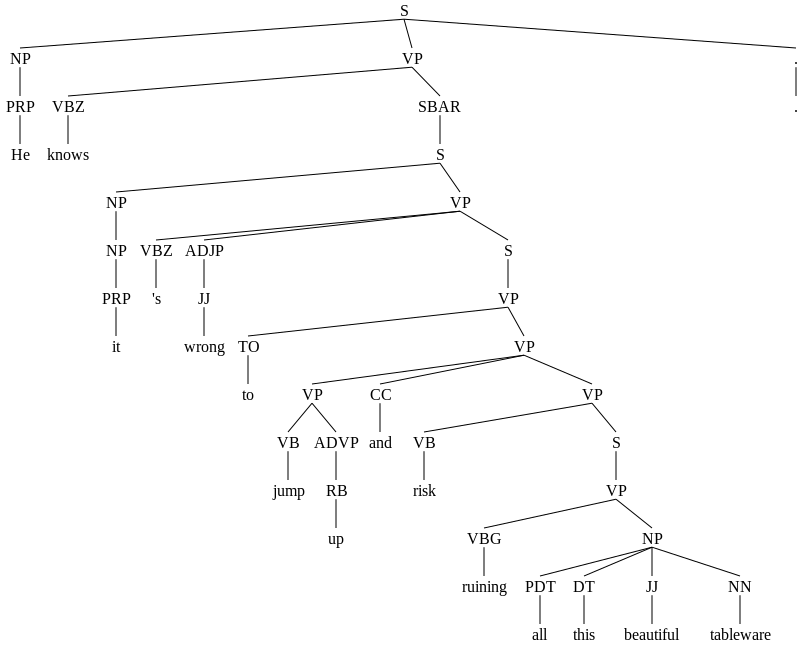

(S (NP (PRP I)) (VP (VBP 'm) (NP (NP (NP (DT a) (NN researcher)) (, ,) (NP (NP (DT a) (NN scientist)) (VP (VBG working) (PP (IN with) (NP (NP (NNS economists)) (, ,) (NP (JJ financial) (NNS economists)) (, ,) (NP (NNS ethicists)) (, ,) (NP (NNS neuroscientists)) (, ,) (NP (NNS lawyers)) (CC and) (NP (NNS others))))))) (VP (VBG trying) (S (VP (TO to) (VP (VB understand) (SBAR (SBAR (WHNP (WP what)) (S (VP (VBZ makes) (S (NP (NNS humans)) (VP (VB tick)))))) (, ,) (CC and) (SBAR (WHADVP (WRB how)) (SQ (MD can) (NP (PRP we)) (VP (VP (VB address) (NP (NP (DT this) (NN issue)) (PP (IN of) (NP (NP (NN fraud)) (PP (IN in) (NP (NNS corporations))))))) (CC and) (ADVP (RB therefore)) (VP (VB contribute) (PP (IN to) (NP (NP (DT the) (NN improvement)) (PP (IN of) (NP (DT the) (NN world)))))))))))))))) (. .))


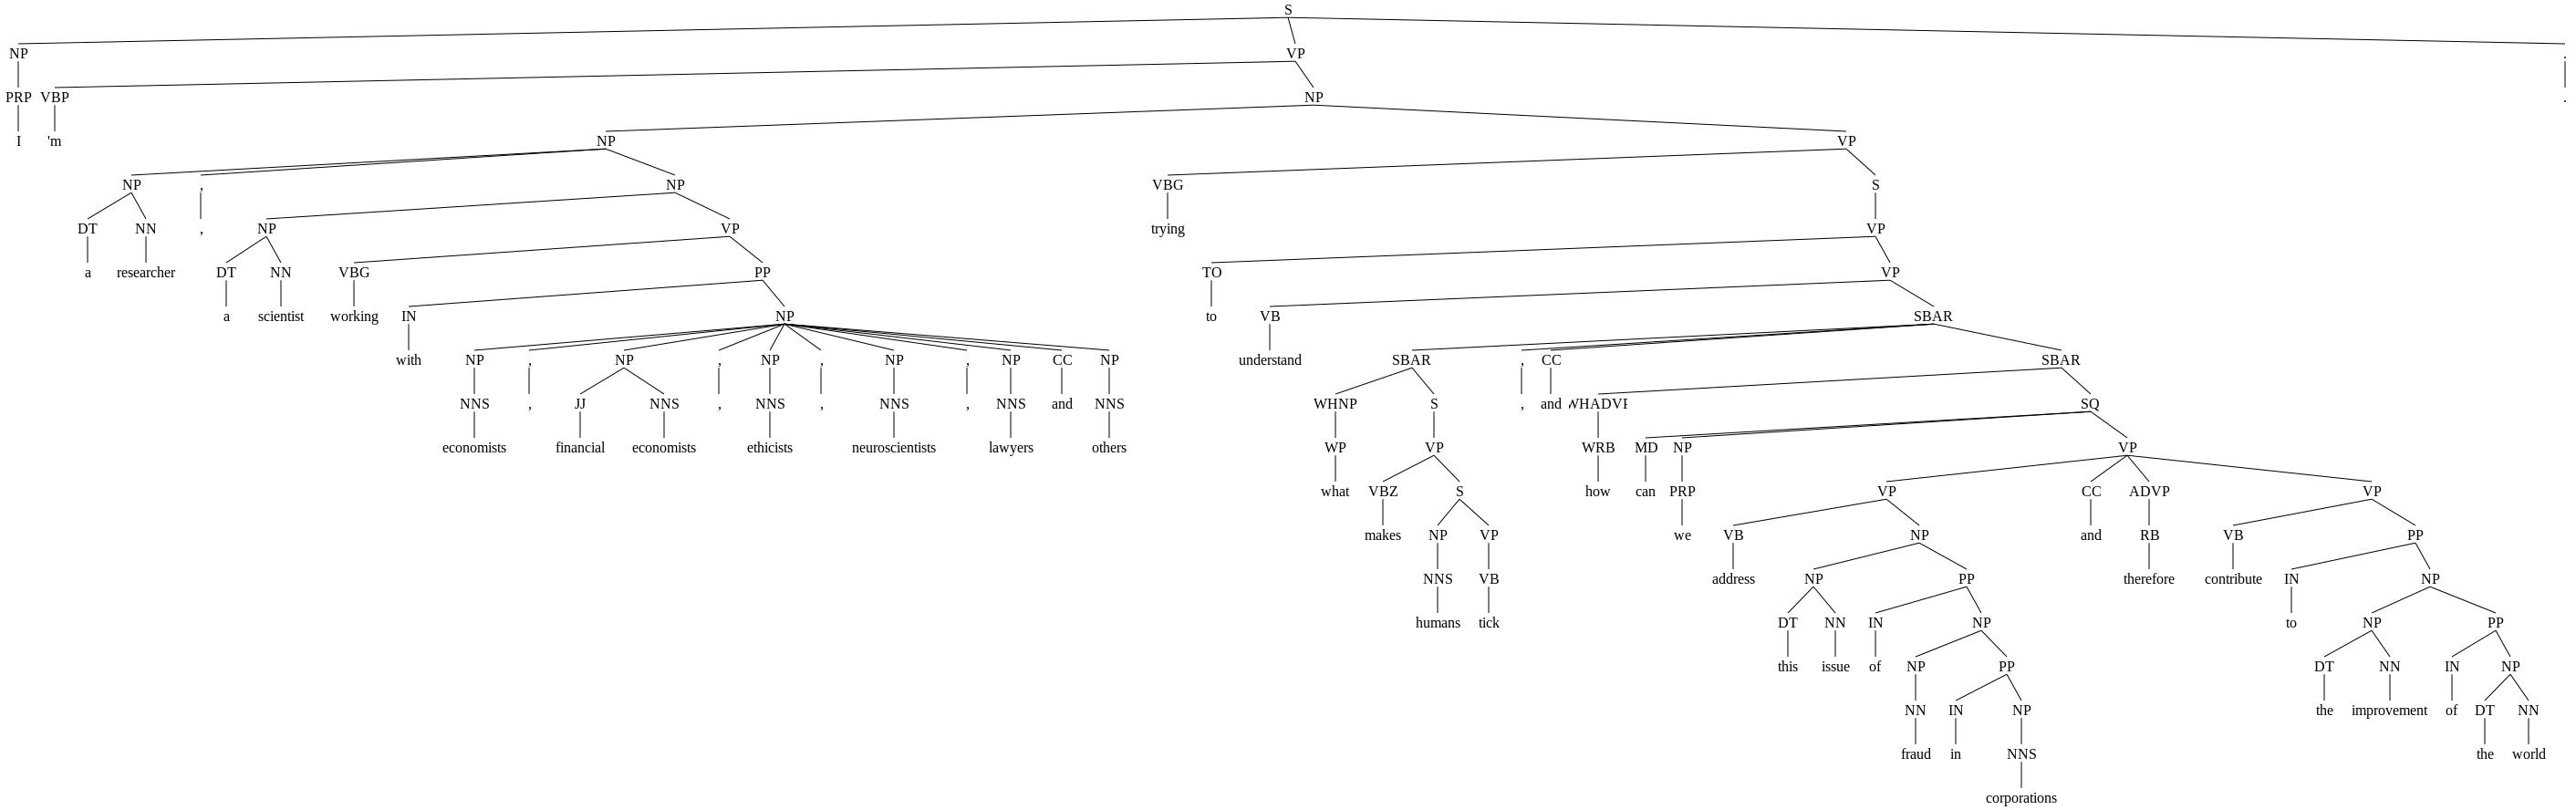

In [50]:
visualize_syntax_tree("You interacted with the company that you work for or that you own.")
visualize_syntax_tree("He knows it's wrong to jump up and risk ruining all this beautiful tableware.")
visualize_syntax_tree("I'm a researcher, a scientist working with economists, financial economists, ethicists, neuroscientists, lawyers and others trying to understand what makes humans tick, and how can we address this issue of fraud in corporations and therefore contribute to the improvement of the world.")

(S (NP (PRP We)) (VP (VBP are) (VP (VBG talking) (ADVP (RB here)) (PP (PP (IN about) (, ,) (ADVP (RB oftentimes)) (, ,) (NP (NP (ADJP (RB very) (JJ young)) (NNS individuals)) (PP (IN with) (NP (NML (JJ spinal) (NN cord)) (NNS injuries))))) (, ,) (SBAR (IN that) (S (S (PP (IN in) (NP (NP (DT the) (NN prime)) (PP (IN of) (NP (PRP$ their) (NN life))))) (S (NP (NNS 20s) (, ,) (NNS 30s) (CC ,) (CD 40s)) (VP (VBD hit) (NP (DT a) (NN wall))))) (CC and) (S (NP (DT the) (NN wheelchair)) (VP (VBZ 's) (NP (DT the) (JJ only) (NN option))))))))) (. .))


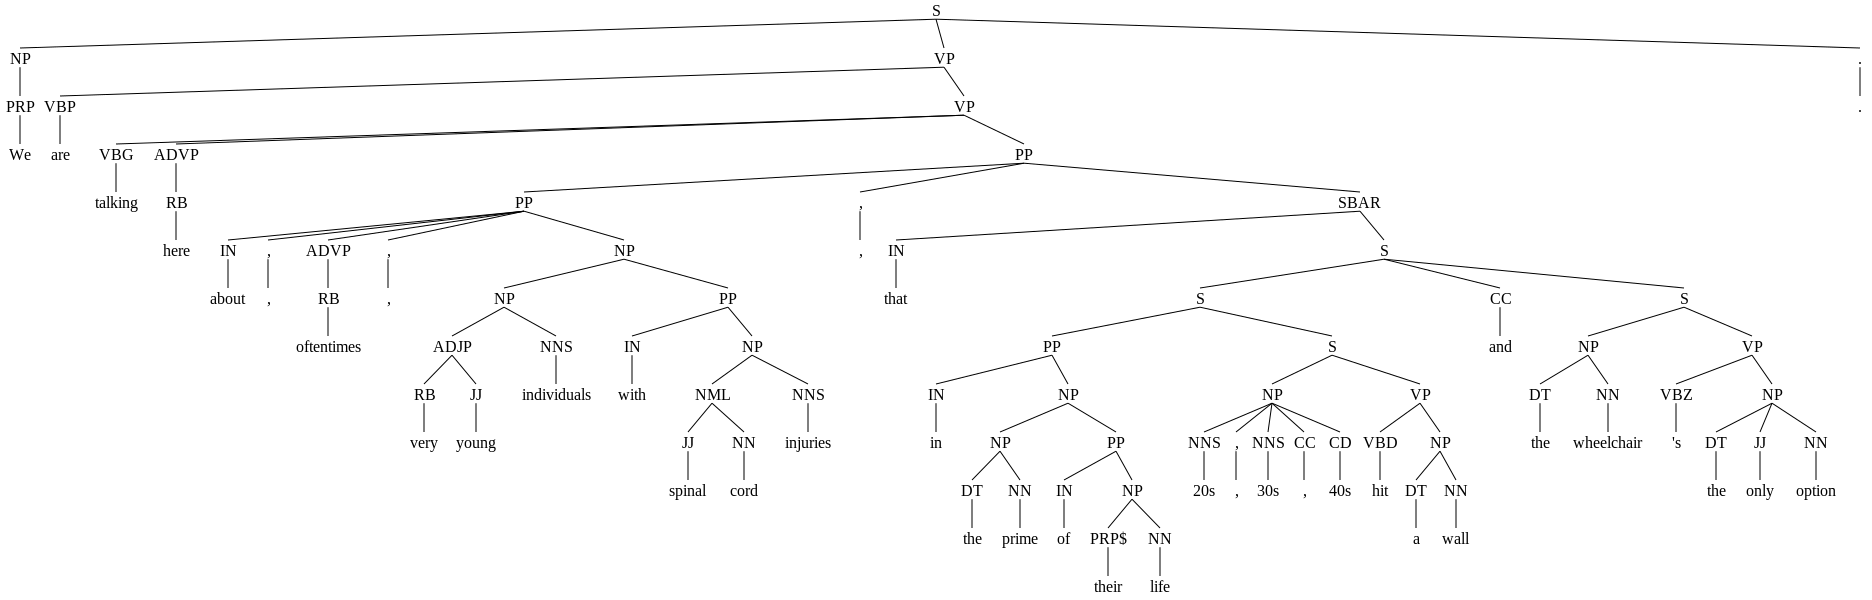

In [53]:
sentence = "We are talking here about, oftentimes, very young individuals with spinal cord injuries, that in the prime of their life  20s, 30s, 40s  hit a wall and the wheelchair's the only option."
sentence = re.sub(r"\s+", " ", sentence).rstrip()
# print(split_sentence_rule1(sentence))
visualize_syntax_tree(sentence)

(S (S (NP (PRP We)) (VP (VBP 're) (VP (VBG moving)))) (PRN (, ,) (S (NP (PRP we)) (VP (VBP 're) (DT all) (VP (VBG moving) (ADVP (RB here))))) (, ,)) (PP (IN to) (NP (NP (DT a) (NN world)) (SBAR (WHADVP (WRB where)) (S (S (NP (NP (DT the) (NNS forces)) (PP (IN of) (NP (NN nature)))) (VP (VBP come) (ADVP (RBR closer) (RB together)) (PP (IN to) (NP (NN technology))))) (, ,) (CC and) (S (NP (NN magic) (CC and) (NN technology)) (VP (MD can) (VP (VB come) (ADVP (RBR closer) (RB together))))))))) (. .))


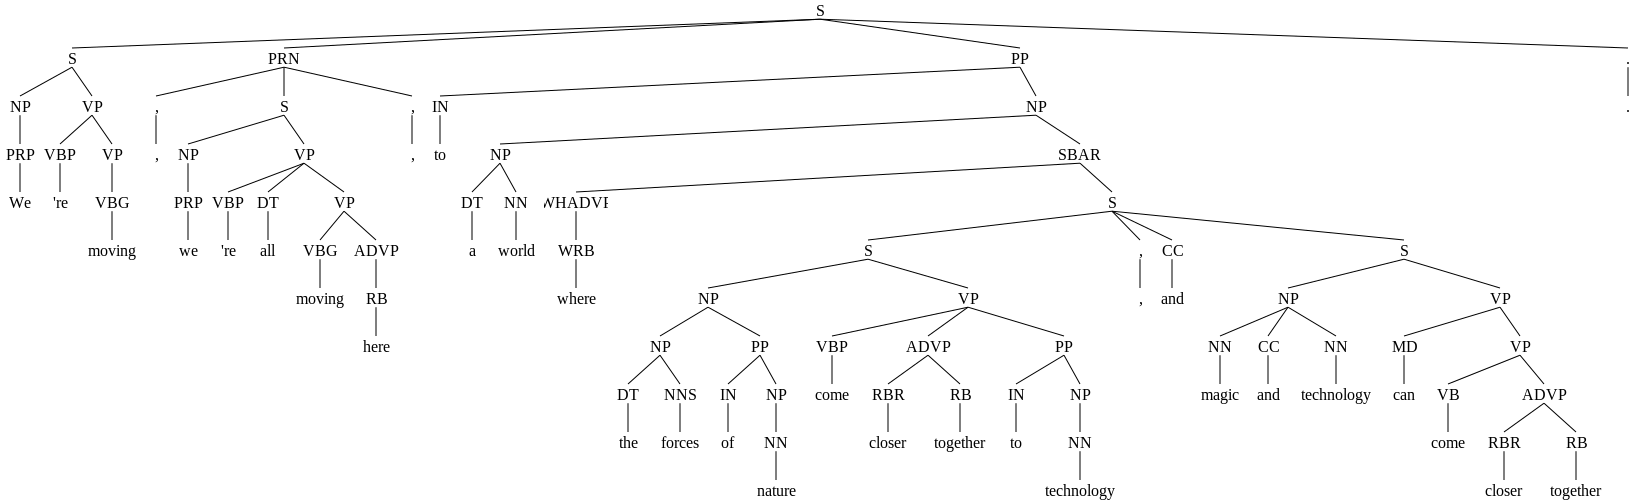

In [141]:
# sentence = "This is [Albert] Gonzalez."
# visualize_syntax_tree(sentence)
# sentence = "This is (Albert) Gonzalez."
# visualize_syntax_tree(sentence)
sentence = "We're moving, we're all moving here, to a world where the forces of nature come closer together to technology, and magic and technology can come closer together."
visualize_syntax_tree(sentence)


## Ex: テキスト解析

You | you | PRON | PRP | nsubj | know subject_tokens= [You]
know | know | VERB | VBP | ROOT | know subject_tokens= [You, know, that, in, fact, he, is, interesting, .]
that | that | SCONJ | IN | mark | is subject_tokens= [that]
in | in | ADP | IN | prep | is subject_tokens= [in, fact]
fact | fact | NOUN | NN | pobj | in subject_tokens= [fact]
he | he | PRON | PRP | nsubj | is subject_tokens= [he]
is | be | AUX | VBZ | ccomp | know subject_tokens= [that, in, fact, he, is, interesting]
interesting | interesting | ADJ | JJ | acomp | is subject_tokens= [interesting]
. | . | PUNCT | . | punct | know subject_tokens= [.]
(S (NP (PRP You)) (VP (VBP know) (SBAR (IN that) (S (PP (IN in) (NP (NN fact))) (NP (PRP he)) (VP (VBZ is) (ADJP (JJ interesting)))))) (. .))


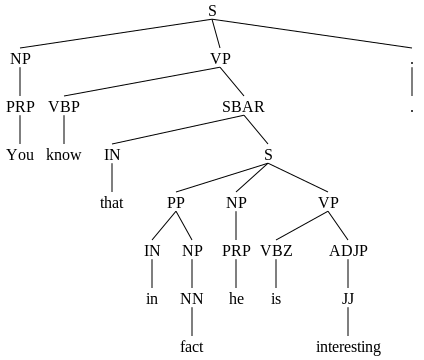

In [7]:
sample_text = "You know that in fact he is interesting."
# テキストを解析
doc = nlp(sample_text)
for token in doc:
    print(token.text, "|", token.lemma_, "|", token.pos_, "|", token.tag_, "|", token.dep_, "|", token.head, "subject_tokens=", [t for t in token.subtree])
visualize_syntax_tree(sample_text)

# ルール1: 節を導く接続詞、関係詞(主語を修飾する場合は除く)の前

* (済)(11/15) 主語を修飾する場合の例外処理は未実装。dependencyを見ればいけるか
  * (11/17) 「節を導く関係詞が文の主部の要素になっている場合」を例外とした
* (11/20) 「ルール1・2は副詞が句・節を修飾している場合、副詞の左で切る」未対応
* (11/30) [ad-hoc] ","がCC扱いで切れるエラーに対処
  * if subtree.label() == "CC" and subtree[0] != ",":

## Code and Examples

In [123]:
def split_sentence_rule1(sentence):
    """
    Split a sentence based on the given rule:
    Rule 1: Before a conjunction or a relative pronoun (except for one modifying a subject)
    """

    def is_subject_np(subtree):
        """
        Check if the subtree is a Noun Phrase acting as a subject in the sentence.
        """
        if hasattr(subtree, "parent") and subtree.parent().label() == "S":
            for sibling in subtree.parent():
                if sibling != subtree and sibling.label() == "VP":
                    return True
        return False

    parsed_tree_string, token_space_mapping = parse_tree(sentence)
    parsed_tree = Tree.fromstring(parsed_tree_string)
    parsed_tree = replace_special_tags_in_tree(parsed_tree)

    def traverse_tree(tree):
        splits = []
        for subtree in tree:
            if type(subtree) == Tree:
                if subtree.label() == "CC" and subtree[0] != ",":
                    splits.append("/ ")
                elif subtree.label() == "SBAR" and not is_subject_np(subtree.parent()):
                    splits.append("/ ")
                splits.extend(traverse_tree(subtree))
            else:
                token_text = token_space_mapping.get(subtree).pop(0)
                splits.append(token_text)
        return splits

    def modifies_subject(tree):
        """
        Check if the given tree modifies a subject.
        """
        if tree.parent() is None:
            return False
        parent_label = tree.parent().label()
        if parent_label in ["S"]:
            return True
        return False

    # Enhance the tree with parent pointers.
    for subtree in parsed_tree.subtrees():
        for child in subtree:
            if type(child) == Tree:
                child.set_label(child.label())
                child.parent = lambda s=subtree: s

    return format_chunked_list(traverse_tree(parsed_tree))

In [124]:
print(split_sentence_rule1("Self-interest isn't a narrowly defined concept just for your immediate utility."))
print(split_sentence_rule1("You interacted with the company that you work for or that you own."))
print(split_sentence_rule1("These frauds cost the shareholders of these companies, and therefore society, on the order of 380 billion dollars per year."))
print(split_sentence_rule1("He knows it's wrong to jump up and risk ruining all this beautiful tableware."))
print(split_sentence_rule1("The game that I developed three years ago is fun."))
print(split_sentence_rule1("I bought the game that I developed three years ago."))
print(split_sentence_rule1("I like Hoge, but I don't like Huga because it isn't tasty."))
print(split_sentence_rule1("You know that actually he is interesting."))
print(split_sentence_rule1("I did'nt go out because it was raining."))

sentence = "We are talking here about, oftentimes, very young individuals with spinal cord injuries, that in the prime of their life  20s, 30s, 40s  hit a wall and the wheelchair's the only option."
sentence = re.sub(r"\s+", " ", sentence).rstrip()
print(split_sentence_rule1(sentence))

Self-interest isn't a narrowly defined concept just for your immediate utility.
You interacted with the company / that you work for / or / that you own.
These frauds cost the shareholders of these companies, / and therefore society, on the order of 380 billion dollars per year.
He knows / it's wrong to jump up / and risk ruining all this beautiful tableware.
The game that I developed three years ago is fun.
I bought the game / that I developed three years ago.
I like Hoge, / but I don't like Huga / because it isn't tasty.
You know / that actually he is interesting.
I did'nt go out / because it was raining.
We are talking here about, oftentimes, very young individuals with spinal cord injuries, / that in the prime of their life 20s, 30s, 40s hit a wall / and the wheelchair's the only option.


# ルール2: to不定詞、前置詞、動名詞の後に3語以上が続く場合

* 左から右へ辿りながらルールを適用
* (済)(11/15) ピリオドも1トークンに含めてしまっているのは要修正
  * (11/17) ピリオドはトークンに含めないように修正した
* (11/20) 「ルール1・2は副詞が句・節を修飾している場合、副詞の左で切る」未対応

## Code and Examples

In [39]:
def split_sentence_rule2(sentence):
    """
    Split a sentence based on the given rule:
    Rule 2: Before a to-infinitive, a preposition, or a gerund followed by three or more words
    """

    def word_to_split(word):
        # preposition
        if word.pos_ == "ADP":
            return True
        # to-infinitive
        if word.pos_ == "PART" and word.text == "to":
            return True
        # gerund
        if word.tag_ == "VBG" and "ing" in word.text:
            return True
        return False

    doc = nlp(sentence)
    words = list(doc)

    splits = []
    count = 0

    for i in range(len(words) -1, -1, -1):
        word = words[i]
        if word.text == ".":
            count -= 1
        count += 1
        if word_to_split(word) and count > 3:
            splits.insert(0, word.text_with_ws)
            splits.insert(0, "/ ")
            count = 0
        else:
            splits.insert(0, word.text_with_ws)

    return format_chunked_list(splits)

In [ ]:
print(split_sentence_rule2("I went to a restaurant to have a fancy dinner."))
print(split_sentence_rule2("I’ve just finished cleaning up my room."))
print(split_sentence_rule2("We hope to improve bilateral relations with your company."))
print(split_sentence_rule2("That's not me who's claiming that, that's the president of the American Finance Association who stated that in his presidential address."))
print(split_sentence_rule2("I am interested in taking a Spanish class."))
print(split_sentence_rule2("I am interested in taking classes."))
print(split_sentence_rule2("Self-interest isn't a narrowly defined concept just for your immediate utility."))

# ルール3: 主語が3語以上で長い場合

## Code and Examples

In [82]:
def split_sentence_rule3(sentence):
    """
    Split a sentence based on the given rule:
    Rule 3: After a long subject (i.e., three or more words)
    """
    doc = nlp(sentence)
    splits = []
    current_split = 0

    for token in doc:
        if "nsubj" in token.dep_:
            subject_tokens = [t for t in token.subtree]
            if len(subject_tokens) >= 3 and token.text_with_ws != token.text:
                split_index = subject_tokens[-1].i + 1
                splits.append(doc[current_split:split_index].text)
                current_split = split_index
    splits.append(doc[current_split:].text)
    return " / ".join(splits)

In [83]:
print(split_sentence_rule3("The quick brown fox that jumps over the lazy dog is very agile."))
print(split_sentence_rule3("The quick brown fox that jumps over the lazy dog is very agile, and he and his brother often plays in the fields."))
print(split_sentence_rule3("The car industry's secrets aren't quite so secret anymore."))
print(split_sentence_rule3("I have a black pen."))
print(split_sentence_rule3("The black pen is mine."))
print(split_sentence_rule3("Self-interest isn't a narrowly defined concept just for your immediate utility."))

The quick brown fox that jumps over the lazy dog / is very agile.
The quick brown fox that jumps over the lazy dog / is very agile, and he and his brother / often plays in the fields.
The car industry's secrets / aren't quite so secret anymore.
I have a black pen.
The black pen / is mine.
Self-interest / isn't a narrowly defined concept just for your immediate utility.


In [85]:
sentence = "Here's Vladimir Tsastsin, from Tartu in Estonia."
print(split_sentence_rule3(sentence))

Here's Vladimir Tsastsin, from Tartu in Estonia.


# ルール4: コンマ(1語ずつの羅列は除く)、セミコロン、ハイフン等の，の前後

- (済)(11/17) 1語ずつの羅列を除く、が意外と厄介
  - (11/19) subtreeの親子関係を見て決定するように修正済み。語の羅列を「commaの前後が両方とも単語である場合」とした。ただし「冠詞+名詞」「形容詞＋名詞」といった2単語からなるNPも1語扱い
  - (11/20) 「形容詞＋名詞」は2単語扱いとするべきとして、2単語かつ「DT+NN(S)」だけ1語扱いにした

## Code and Examples

In [126]:
def split_sentence_rule4(sentence):
    """
    Split a sentence based on the given rule:
    Rule 4: Before or after a comma (except one used for listing in a series of words), a semicolon, a hyphen, or other marks of punctuation
    """

    def is_subject_np(subtree):
        """
        Check if the subtree is a Noun Phrase acting as a subject in the sentence.
        """
        parent = subtree.parent()
        if parent and parent.label() == "S":
            for sibling in parent:
                if sibling != subtree and sibling.label() == "VP":
                    return True
        return False

    def check_words_listed(tree, i):
        """
        Check if comma is used for a list of series of words.
        """
        prev_comma = tree[i-2]
        next_comma = tree[i]
        if next_comma.label() == "CC":
            next_comma = tree[i+1]
        if len(prev_comma.leaves()) + len(next_comma.leaves()) >= 5:
            return False
        elif len(prev_comma.leaves()) + len(next_comma.leaves()) <= 2:
            # If the sum of the subtree lengths before and after the comma \
            # is less than 2, it is considered part of a word list
            return True
        else:
            # case of length 3~4; Returns True if both subtrees are "DT+NN or length 1"
            # breakpoint()
            return  (len(prev_comma.leaves()) == 1 or \
                (prev_comma[0].label() == "DT" and prev_comma[1].label() in "NNS")) and \
                (len(next_comma.leaves()) == 1 or \
                (next_comma[0].label() == "DT" and next_comma[1].label() in "NNS"))

    parsed_tree_string, token_space_mapping = parse_tree(sentence)
    parsed_tree = Tree.fromstring(parsed_tree_string)
    parsed_tree = replace_special_tags_in_tree(parsed_tree)

    def traverse_tree(tree):
        splits = []
        for i, subtree in enumerate(tree):
            if type(subtree) == Tree:
                if i > 0:
                    if tree[i-1].label() == ":":
                        splits.append("/ ")
                    elif i > 1 and tree[i-1].label() == "," \
                        and not check_words_listed(tree, i):
                        splits.append("/ ")
                splits.extend(traverse_tree(subtree))
            else:
                token_text = token_space_mapping.get(subtree).pop(0)
                splits.append(token_text)
        if type(subtree) == Tree and subtree.label() in [":", ","]:
            # Case where the rightmost child is a symbol
            splits.append("/ ")
        return splits

    # Enhance the tree with parent pointers.
    for subtree in parsed_tree.subtrees():
        for child in subtree:
            if type(child) == Tree:
                child.set_label(child.label())
                child.parent = lambda s=subtree: s

    return format_chunked_list(traverse_tree(parsed_tree))

In [ ]:
print(split_sentence_rule4("I like apples, oranges, and bananas."))
print(split_sentence_rule4("I like apples, oranges, and sweety bananas."))
print(split_sentence_rule4("I like an apple, an orange, and bananas."))
print(split_sentence_rule4("I like apples, oranges, and -- bananas; actually, I don't like - fruits."))
print(split_sentence_rule4("I like eating apples, bananas, and sweety cherries, and playing the piano."))  # 接続詞の入れ子
print(split_sentence_rule4("I like watching TV, playing guitar, swimming, dancing, and playing piano."))
print(split_sentence_rule4("Well, you got up in the morning, took a shower, washed your hair, ate cereals, fruit, yogurt, whatever - had coffee - tea."))
print(split_sentence_rule4("These frauds cost the shareholders of these companies, and therefore society, on the order of 380 billion dollars per year."))  # 副詞が挟まるケースは無視
print(split_sentence_rule4("Self-interest isn't a narrowly defined concept just for your immediate utility."))
print(split_sentence_rule4("His basic idea was that if everybody behaves in their own self-interests, that's good for everybody in the end."))

# ルール5: 文頭の前置詞句、副詞句の後

* (済)(11/17) 未対応「文頭に前置詞句・副詞句が連続する場合は、それぞれで区切る」
* (済)(11/17) 未対応「節を導く接続詞・関係詞の直後に前置詞句・副詞句が続く場合も区切る」。「スラッシュの直後の前置詞句、副詞句の後」ということにして、ルール1の次に適用すれば良いか?
  * (11/20) 「長女PP/ADVPの”親”（`parent`）の”姉”（`left_siblings[-1]`）がCCであれば切る」「長女PP/ADVPの”親”がSでその”親”がSBARで主語を修飾していなければ切る」とした
  * (11/20) CCに関して「長女PP/ADVPの”姉”（left_siblings[-1]）、または”親”（parent）の”姉”（left_siblings[-1]）がCCであれば切る」とした

## Code and Examples

In [148]:
def split_sentence_rule5(sentence):
    """
    Split a sentence based on the given rule:
    Rule 5: After an adverbial phrase or a prepositional phrase that is either at the beginning of a sentence
            or right after a subordinating conjunction or relative pronoun.
    """
    def set_left_siblings(tree, left_siblings=[]):
        for child in tree:
            if type(child) == Tree:
                child.left_siblings = list(left_siblings)
                left_siblings.append(child)
                set_left_siblings(child, left_siblings=[])

    def is_subject_np(subtree):
        """
        Check if the subtree is a Noun Phrase acting as a subject in the sentence.
        """
        parent = subtree.parent()
        if parent and parent.label() == "S":
            for sibling in parent:
                if sibling != subtree and sibling.label() == "VP":
                    return True
        return False

    def is_clause_led_by_conjunction(subtree):
        """
        Check if the subtree is a clause led by a subordinating conjunction.
        """
        if len(subtree.left_siblings) == 0:
             return False
        return subtree.left_siblings[-1].label() == "CC"

    def is_clause_led_by_relative_pronoun(subtree):
        """
        Check if the subtree is a clause led by a relative pronoun.
        """
        return subtree.label() == "SBAR" and not is_subject_np(subtree.parent())

    parsed_tree_string, token_space_mapping = parse_tree(sentence)
    parsed_tree = Tree.fromstring(parsed_tree_string)
    parsed_tree = replace_special_tags_in_tree(parsed_tree)

    def traverse_tree(tree, depth):
        splits = []

        # is_bos to handle cases where PP or ADVP occur consecutively
        # at the beginning of a sentence
        is_bos = False
        if depth == 0:
            is_bos = True
        for i, subtree in enumerate(tree):
            if type(subtree) == Tree:

                splits.extend(traverse_tree(subtree, depth+1))

                # case1: at the beginning of a sentence
                if is_bos and subtree.label() in ["PP", "ADVP"]:
                    splits.append("/ ")
                elif subtree.label() == ",":
                    if len(splits) > 1 and splits[-2] == "/ ":
                        splits[-1], splits[-2] = splits[-2], splits[-1]
                else:
                    is_bos = False

                    if subtree.label() in ["PP", "ADVP"] and \
                        (subtree.left_siblings == [] or is_clause_led_by_conjunction(subtree)):
                        # case 2: right after conjunction
                        if is_clause_led_by_conjunction(subtree) or is_clause_led_by_conjunction(tree):
                            splits.append("/ ")
                        # case 3: right after relative pronoun
                        if tree.label() == "S" and hasattr(tree, "parent") \
                            and is_clause_led_by_relative_pronoun(tree.parent()):
                            splits.append("/ ")
            else:
                token_text = token_space_mapping.get(subtree).pop(0)
                splits.append(token_text)
        return splits

    # Add left siblings of subtrees.
    set_left_siblings(parsed_tree)

    # Enhance the tree with parent pointers.
    for subtree in parsed_tree.subtrees():
        for child in subtree:
            if type(child) == Tree:
                child.set_label(child.label())
                child.parent = lambda s=subtree: s

    return format_chunked_list(traverse_tree(parsed_tree, depth=0))

In [149]:
print("# 文頭")
print(split_sentence_rule5("In fact this past weekend we had one of our trucks."))  # 文頭のPP # [ok]
print(split_sentence_rule5("So what does that leave us with?"))  # 文頭の副詞句 # [ok]
print(split_sentence_rule5("So in my talk today, I want to share with you some insights."))  # 文頭の副詞句 .. 副詞"RB"扱いで取れない。このままで良い？
print(split_sentence_rule5("Before sunrise, the city was eerily quiet.")) # [ok]
print(split_sentence_rule5("After the movie, we decided to go for a walk.")) # [ok]
print(split_sentence_rule5("Without hesitation, she accepted the challenge.")) # [ok]
print(split_sentence_rule5("In case of emergency, break the glass.")) # [ok]
print(split_sentence_rule5("In our research, we look at this.")) # [ok]
print(split_sentence_rule5("So what does that leave us with?")) # [ok]
print()
print("# 文頭の連続")
print(split_sentence_rule5("In the morning, after eating breakfast, John went to school."))  # 文頭のPPの連続 # [ok]
print(split_sentence_rule5("Behind the house, beyond the old oak tree, there is a hidden garden."))   # 文頭のPPの連続 # [ok]
print()
print("# 節を導く接続詞の直後に前置詞句・副詞句が続く")
print(split_sentence_rule5("I took part in a business plan contest, and in the interview I was asked about my plan."))  # CC → PP # [ok]
print(split_sentence_rule5("I went to the library, and there I bought a book."))  # CC → ADVP # [ok]
print(split_sentence_rule5("We try to build a reputation, maybe for being honest, because then people trust us more in the future.")) # CC → ADVP # [ok]
print()
print("# 節を導く関係詞の直後に前置詞句・副詞句が続く")
print(split_sentence_rule5("You know that in fact he is interesting."))  # 関係詞 → PP # [ok]
print(split_sentence_rule5("This is the place where, at the break of dawn, the birds start singing."))  # 関係詞 → PP  # [ok]
print(split_sentence_rule5("I know the boy who really like books."))  # 関係詞 → ADVP # [ok]
print(split_sentence_rule5("The book, in which the author discusses various scientific theories, has received critical acclaim."))  # これは例が間違っている、切らないでOK
print(split_sentence_rule5("She visited the town where, during her childhood, she spent many summers."))  # [ok]
print(split_sentence_rule5("He remembers the moment when, under the starry sky, he first realized his love for astronomy."))  # [ok]
print(split_sentence_rule5("This is the place where, at the break of dawn, the birds start singing."))  # [ok]
print(split_sentence_rule5("I still think about the time when, in the middle of the storm, we found shelter in an old cabin."))  # [ok]

print()
print(split_sentence_rule5("Self-interest isn't a narrowly defined concept just for your immediate utility."))

# 文頭
In fact / this past weekend we had one of our trucks.
So / what does that leave us with?
So in my talk today, I want to share with you some insights.
Before sunrise, / the city was eerily quiet.
After the movie, / we decided to go for a walk.
Without hesitation, / she accepted the challenge.
In case of emergency, / break the glass.
In our research, / we look at this.
So / what does that leave us with?

# 文頭の連続
In the morning, / after eating breakfast, / John went to school.
Behind the house, / beyond the old oak tree, / there is a hidden garden.

# 節を導く接続詞の直後に前置詞句・副詞句が続く
I took part in a business plan contest, and in the interview / I was asked about my plan.
I went to the library, and there / I bought a book.
We try to build a reputation, maybe for being honest, because then / people trust us more in the future.

# 節を導く関係詞の直後に前置詞句・副詞句が続く
You know that in fact / he is interesting.
This is the place where, at the break of dawn, / the birds start singing.
I know the boy who really /

In [150]:
sentence = "We're moving, we're all moving here, to a world where the forces of nature come closer together to technology, and magic and technology can come closer together."
print(split_sentence_rule5(sentence))
# print(split_sentence_rule5("In fact, this past weekend we had one of our trucks."))  # 文頭のPP # [ok]


We're moving, we're all moving here, to a world where the forces of nature come closer together to technology, and magic and technology can come closer together.


# ルール1-5

- 適用順序は、「1, 3, 4, 5」 -> 2

## Code

In [130]:
def merge_chunked_strings(strings):
    words = [[] for _ in strings]
    slash_positions = [[] for _ in strings]
    for i, s in enumerate(strings):
        words_with_slash = s.split()
        words[i] = []
        slash_positions[i] = []
        w_pre = ""
        for w in words_with_slash:
            if w != "/":
                words[i].append(w)
            if w_pre != "/" and w_pre != "":
                slash_positions[i].append(w == "/")
            w_pre = w
        slash_positions[i].append(False)

    merged = []
    slash_positions_merged = [any(elements) for elements in zip(*slash_positions)]
    for i in range(len(words[0])):
        merged.append(words[0][i])
        if slash_positions_merged[i]:
            merged.append("/")

    return " ".join(merged)

In [19]:
def split_sentence_rule2_chunked_input(sentence_with_slash):
    """
    Split a chunked sentence based on the given rule:
    Rule 2: Before a to-infinitive, a preposition, or a gerund followed by three or more words
    """

    def word_to_split(word):
        # preposition
        if word.pos_ == "ADP":
            return True
        # to-infinitive
        if word.pos_ == "PART" and word.text == "to":
            return True
        # gerund
        if word.tag_ == "VBG" and "ing" in word.text:
            return True
        return False

    # tokenize each word by SpaCy
    words_with_slash = sentence_with_slash.split()
    words_with_slash_spacy = []
    for word in words_with_slash:
        doc = nlp(word)
        words_with_slash_spacy.extend([token.text for token in doc])

    # get slash_positions (e.g. [False, False, True, False, ...])
    words = []
    slash_positions = []
    w_pre = ""
    for w in words_with_slash_spacy:
        if w != "/":
            words.append(w)
        if w_pre != "/" and w_pre != "":
            slash_positions.append(w == "/")
        w_pre = w
    slash_positions.append(False)

    doc = nlp(format_chunked_list(sentence_with_slash.replace("/ ","")))
    words = list(doc)

    splits = []
    count = 0

    for i in range(len(words) -1, -1, -1):
        word = words[i]
        if slash_positions[i]:
            count = 0
        if word.text == ".":
            count -= 1
        count += 1
        if word_to_split(word) and count > 3:
            splits.insert(0, word.text_with_ws)
            splits.insert(0, "/ ")
            count = 0
        else:
            splits.insert(0, word.text_with_ws)

    return merge_chunked_strings([sentence_with_slash, format_chunked_list(splits)])

In [20]:
def split_sentence_by_five_rules(sentence):

    # Rule 1, 3, 4, 5
    chunked_strings = [
        split_sentence_rule1(sentence),
        split_sentence_rule3(sentence),
        split_sentence_rule4(sentence),
        split_sentence_rule5(sentence),
    ]
    merged_chunked_strings = merge_chunked_strings(chunked_strings)

    # Rule 2
    return split_sentence_rule2_chunked_input(merged_chunked_strings)

## Examples

In [ ]:
print(split_sentence_rule2_chunked_input("Self-interest isn't a narrowly defined concept just for your immediate utility."))
print(split_sentence_rule2_chunked_input("Self-interest / isn't / a narrowly defined concept just for your immediate utility."))

In [ ]:
sentence = "The quick brown fox that jumps over the lazy dog is very agile, and he and his brother often plays in the fields."
print("Rule 1:              ", split_sentence_rule1(sentence))
print("Rule 3:              ", split_sentence_rule3(sentence))
print("Rule 4:              ", split_sentence_rule4(sentence))
print("Rule 5:              ", split_sentence_rule5(sentence))

chunked_strings = [
    split_sentence_rule1(sentence),
    split_sentence_rule3(sentence),
    split_sentence_rule4(sentence),
    split_sentence_rule5(sentence),
]
merged_chunked_strings = merge_chunked_strings(chunked_strings)
print("Rule 1,3,4,5:    ", merged_chunked_strings)

print("Rule 1,2,3,4,5: ", split_sentence_rule2_chunked_input(merged_chunked_strings))

In [ ]:
# ale_chunk.txt: L106

# I'm a researcher, /4
# a scientist /1
# working with economists, /4
# financial economists, /4
# ethicists, neuroscientists, lawyers and others /1
# trying to understand /1
# what makes humans tick, /4
# and how can we address this issue /2
# of fraud in corporations /1
# and therefore /5
# contribute to the improvement of the world

sentence = "I'm a researcher, a scientist working with economists, financial economists, ethicists, neuroscientists, lawyers and others trying to understand what makes humans tick, and how can we address this issue of fraud in corporations and therefore contribute to the improvement of the world."

print("Rule 1:              ", split_sentence_rule1(sentence))
print("Rule 3:              ", split_sentence_rule3(sentence))
print("Rule 4:              ", split_sentence_rule4(sentence))
print("Rule 5:              ", split_sentence_rule5(sentence))

chunked_strings = [
    split_sentence_rule1(sentence),
    split_sentence_rule3(sentence),
    split_sentence_rule4(sentence),
    split_sentence_rule5(sentence),
]
merged_chunked_strings = merge_chunked_strings(chunked_strings)
print("Rule 1,3,4,5:    ", merged_chunked_strings)

print("Rule 1,2,3,4,5: ", split_sentence_rule2_chunked_input(merged_chunked_strings))

In [ ]:
# ale_chunk.txt: L272
# If you believe /1
# that people are motivated like that, /4
# then /5
# all the stuff about incentives, /4
# all the stuff /2
# about code of conduct and bonus systems and so on, /3&4
# doesn't make a whole lot of sense.

sentence = "If you believe that people are motivated like that, then all the stuff about incentives, all the stuff about code of conduct and bonus systems and so on, doesn't make a whole lot of sense."

print("Rule 1:              ", split_sentence_rule1(sentence))
print("Rule 3:              ", split_sentence_rule3(sentence))
print("Rule 4:              ", split_sentence_rule4(sentence))
print("Rule 5:              ", split_sentence_rule5(sentence))

chunked_strings = [
    split_sentence_rule1(sentence),
    split_sentence_rule3(sentence),
    split_sentence_rule4(sentence),
    split_sentence_rule5(sentence),
]
merged_chunked_strings = merge_chunked_strings(chunked_strings)
print("Rule 1,3,4,5:    ", merged_chunked_strings)

print("Rule 1,2,3,4,5: ", split_sentence_rule2_chunked_input(merged_chunked_strings))

### 全ルールの適用

In [ ]:
# ale_chunk.txt: L272
# If you believe /1
# that people are motivated like that, /4
# then /5
# all the stuff about incentives, /4
# all the stuff /2
# about code of conduct and bonus systems and so on, /3&4
# doesn't make a whole lot of sense.

sentence = "If you believe that people are motivated like that, then all the stuff about incentives, all the stuff about code of conduct and bonus systems and so on, doesn't make a whole lot of sense."
print(split_sentence_by_five_rules(sentence))

In [65]:
import re
sentence = "We are talking here about, oftentimes, very young individuals with spinal cord injuries, that in the prime of their life  20s, 30s, 40s  hit a wall and the wheelchair's the only option."
sentence = re.sub(r"\s+", " ", sentence).rstrip()
print(split_sentence_rule1(sentence))
print(split_sentence_by_five_rules(sentence))

We are talking here about, oftentimes, very young individuals with spinal cord injuries, / that in the prime of their life 20s, 30s, 40s hit a wall / and the wheelchair's the only option.
> <ipython-input-44-ae46c22d4759>(3)merge_chunked_strings()
      1 def merge_chunked_strings(strings):
      2     breakpoint()
----> 3     words = [[] for _ in strings]
      4     slash_positions = [[] for _ in strings]
      5     for i, s in enumerate(strings):

ipdb> exit()


In [132]:
#sentence = "Here's Vladimir Tsastsin, from Tartu in Estonia."
sentence = "This is [Albert] Gonzalez."
sentence = "We're moving, we're all moving here, to a world where the forces of nature come closer together to technology, and magic and technology can come closer together."
print(split_sentence_by_five_rules(sentence))

IndexError: ignored

# オプション： merge_chunks

## Code and Examples

In [21]:
def merge_chunks(chunked_sentence, min_chunk):
    """
    Merges chunks of a text that are separated by slashes such that each chunk has at least X words.

    :param chunked_sentence: The input text with chunks separated by slashes.
    :param min_chunk: The minimum number of words each chunk should have.
    :return: The modified text with merged chunks.
    """
    chunks = chunked_sentence.split(" / ")
    merged_chunks = []
    current_chunk = []

    for chunk in chunks:
        current_chunk.append(chunk)
        if sum(len(c.split()) for c in current_chunk) < min_chunk:
            continue
        merged_chunks.append(' '.join(current_chunk))
        current_chunk = []

    # Add any remaining words as a chunk
    if current_chunk:
        merged_chunks.append(' '.join(current_chunk))

    return " / ".join(merged_chunks)

In [40]:
min_chunk = 2
chunked_sentence = "So / in my talk today, / I / want / to / share / with you some insights / I've obtained."
print(merge_chunks(chunked_sentence, min_chunk))
print(merge_chunks(chunked_sentence, min_chunk+1))

So in my talk today, / I want / to share / with you some insights / I've obtained.
So in my talk today, / I want to / share with you some insights / I've obtained.


# デモ

## ルール1: 節を導く接続詞、関係詞(主語を修飾する場合は除く)の前

In [ ]:
print(split_sentence_rule1("You interacted with the company that you work for or that you own."))
print(split_sentence_rule1("These frauds cost the shareholders of these companies, and therefore society, on the order of 380 billion dollars per year."))
print(split_sentence_rule1("He knows it's wrong to jump up and risk ruining all this beautiful tableware."))
print(split_sentence_rule1("The game that I developed three years ago is fun."))
print(split_sentence_rule1("I bought the game that I developed three years ago."))
print(split_sentence_rule1("I like Hoge, but I don't like Huga because it isn't tasty."))

In [ ]:
while True:
    sentence = input()
    print(split_sentence_rule1(sentence))

## ルール2: to不定詞、前置詞、動名詞の後に3語以上が続く場合

In [ ]:
print(split_sentence_rule2("I went to a restaurant to have a fancy dinner."))
print(split_sentence_rule2("I’ve just finished cleaning up my room."))
print(split_sentence_rule2("We hope to improve bilateral relations with your company."))
print(split_sentence_rule2("That's not me who's claiming that, that's the president of the American Finance Association who stated that in his presidential address."))
print(split_sentence_rule2("I am interested in taking a Spanish class."))
print(split_sentence_rule2("I am interested in taking classes."))

In [ ]:
while True:
    sentence = input()
    print(split_sentence_rule2(sentence))

## ルール3: 主語が3語以上で長い場合

In [ ]:
print(split_sentence_rule3("The quick brown fox that jumps over the lazy dog is very agile."))
print(split_sentence_rule3("The quick brown fox that jumps over the lazy dog is very agile, and he and his brother often plays in the fields."))
print(split_sentence_rule3("The car industry's secrets aren't quite so secret anymore."))
print(split_sentence_rule3("I have a black pen."))
print(split_sentence_rule3("The black pen is mine."))

In [ ]:
while True:
    sentence = input()
    print(split_sentence_rule3(sentence))

## ルール4: コンマ(1語ずつの羅列は除く)、セミコロン、ハイフン等の記号の前後

In [ ]:
print(split_sentence_rule4("Well, you got up in the morning, took a shower, washed your hair, ate cereals, fruit, yogurt, whatever -- had coffee -- tea."))
print(split_sentence_rule4("Well, you got up in the morning, took a shower, washed your hair, ate cereals, fruit, yogurt, whatever - had coffee - tea."))
print(split_sentence_rule4("I like an apple, an orange, and a banana."))
print(split_sentence_rule4("I like apples, oranges, and bananas."))

In [ ]:
while True:
    sentence = input()
    print(split_sentence_rule4(sentence))

## ルール5: 文頭の前置詞句、副詞句の後


In [ ]:
print(split_sentence_rule5("In fact this past weekend we had one of our trucks."))
print(split_sentence_rule5("In our research, we look at this."))
print(split_sentence_rule5("So what does that leave us with?"))
print(split_sentence_rule5("In other words, it will pay off to put people first."))

In [ ]:
while True:
    sentence = input()
    print(split_sentence_rule5(sentence))

## ルール 1-5

In [ ]:
# ale_chunk.txt: L272
# If you believe /1
# that people are motivated like that, /4
# then /5
# all the stuff about incentives, /4
# all the stuff /2
# about code of conduct and bonus systems and so on, /3&4
# doesn't make a whole lot of sense.

sentence = "If you believe that people are motivated like that, then all the stuff about incentives, all the stuff about code of conduct and bonus systems and so on, doesn't make a whole lot of sense."
print(split_sentence_by_five_rules(sentence))

In [ ]:
while True:
    sentence = input()
    print(split_sentence_by_five_rules(sentence))

## オプション: merge_chunks

In [ ]:
sentence = "So in my talk today, I want to share with you some insights I've obtained."
print(merge_chunks(split_sentence_by_five_rules(sentence), min_chunk=1))
print(merge_chunks(split_sentence_by_five_rules(sentence), min_chunk=2))
print(merge_chunks(split_sentence_by_five_rules(sentence), min_chunk=3))

In [ ]:
while True:
    sentence = input()
    print(merge_chunks(split_sentence_by_five_rules(sentence), min_chunk=1))
    print(merge_chunks(split_sentence_by_five_rules(sentence), min_chunk=2))
    print(merge_chunks(split_sentence_by_five_rules(sentence), min_chunk=3))

# 評価
- Talk: AlexanderWagner_2016X
- 入力データ: `ale_sampled.txt`
- 人手チャンク化データ： `ale_sampled_chunk.txt`
- 結果
  - ale_sampled: F1/P/R = 0.721/0.679/0.768
  - nic_sampled: F1/P/R = 0.772/0.747/0.798
  - lau_sampled: F1/P/R = 0.774/0.737/0.816
  - total: F1/P/R = 0.738/0.721/0.755 -> バグあり
  - 人間同士 (0.74/0.90/0.63) と比べても悪くない数字？ (Doi+, Table 4)
- 結果 (min_chunk={1,2,3}) -> バグあり
    - total: F1/P/R = 0.738/0.721/0.755
    - total (min=2): F1/P/R = 0.717/0.737/0.697
    - total (min=3): F1/P/R = 0.672/0.738/0.617
- バグ修正後
    - total (min=1): F1/P/R = 0.759/0.725/0.797
    - total (min=2): F1/P/R = 0.738/0.741/0.736
    - total (min=3): F1/P/R = 0.694/0.742/0.651

## Ex: Step-by-Step

### 予測

In [26]:
with open('ale_sampled.txt', 'r') as file:
    ale_sampled_text = file.readlines()

prediction = []
for sentence in ale_sampled_text:
    prediction.append(split_sentence_by_five_rules(sentence.rstrip()))
    print(prediction[-1])

# Splitting the prediction sentences into chunks
predicted_chunks = []
for sentence in prediction:
    chunks = sentence.split(' / ')
    predicted_chunks.append(chunks)

for pred in predicted_chunks[:3]:
    print(pred)

How many companies / have you interacted with today?
I'm pretty sure / there are / at least seven companies / you've interacted with today.
We can all think / of some examples, / right?
So / in my talk today, / I want to share / with you some insights / I've obtained / and learned / in the last 10 years of / conducting research in this.
I'm a researcher, / a scientist / working with economists, / financial economists, / ethicists, neuroscientists, lawyers / and others trying to understand / what makes humans tick, / and / how can we address this issue / of fraud in corporations / and therefore / contribute / to the improvement of the world.
Self-interest / isn't a narrowly defined concept just / for your immediate utility.
That might be us.
So my friend Adam here / might jump up, / get the sausage / and thereby / ruin all this beautiful tableware.
And then / if you behave according / to that code of conduct, / that improves your chances of / getting a bonus payment.
Similarly, / reputa

### F1/P/R

In [24]:
reference_chunks = []
current_sentence = []

with open('ale_sampled_chunk.txt', 'r') as file:
    for line in file:
        # Strip any trailing characters (like newline or space)
        stripped_line = line.strip()

        # Check if the line is an empty line, indicating the end of a sentence
        if not stripped_line:
            if current_sentence:
                # Add the current sentence to the formatted chunks
                reference_chunks.append(current_sentence)
                current_sentence = []  # Reset for the next sentence
        else:
            # Add only the text part of the chunk, excluding any trailing characters like '/4'
            chunk = stripped_line.split(' /')[0]  # Splitting at space followed by '/'
            current_sentence.append(chunk)

# Add the last sentence if the file doesn't end with an empty line
if current_sentence:
    reference_chunks.append(current_sentence)

for ref in reference_chunks[:3]: # Displaying few examples for verification
    print(ref)

['How many companies have you interacted with today?']
["I'm pretty sure", 'there are at least seven companies', "you've interacted with today."]
['We can all think of some examples,', 'right?']


In [27]:
def calculate_f1_precision_recall(predicted, correct):
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    # Loop through each sentence and its predicted chunks
    for pred_chunks, corr_chunks in zip(predicted, correct):

        # Create a set of positions where the correct chunks end
        correct_positions = set()
        position = 0
        for chunk in corr_chunks[:-1]:
            position += len(chunk.split())  # Count the words in the chunk
            correct_positions.add(position)

        # Create a set of positions where the predicted chunks end
        predicted_positions = set()
        position = 0
        for chunk in pred_chunks[:-1]:
            position += len(chunk.split())  # Count the words in the chunk
            predicted_positions.add(position)

        # Calculate TP, FP, FN
        for pos in predicted_positions:
            if pos in correct_positions:
                true_positives += 1
            else:
                false_positives += 1

        for pos in correct_positions:
            if pos not in predicted_positions:
                false_negatives += 1

    # Calculating Precision, Recall, and F1 Score
    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

    return f1, precision, recall

# Calculate F1, Precision, and Recall
f1_score, precision, recall = calculate_f1_precision_recall(predicted_chunks, reference_chunks)
# f1_score, precision, recall = calculate_f1_precision_recall(predicted_chunks, predicted_chunks)
print(f"F1/P/R = {f1_score:.3f}/{precision:.3f}/{recall:.3f}")

F1/P/R = 0.721/0.679/0.768


## Code

In [35]:
from tqdm import tqdm


def calculate_f1_precision_recall(predicted, correct):
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    # Loop through each sentence and its predicted chunks
    for pred_chunks, corr_chunks in zip(predicted, correct):

        # Create a set of positions where the correct chunks end
        correct_positions = set()
        position = 0
        for chunk in corr_chunks[:-1]:
            position += len(chunk.split())  # Count the words in the chunk
            correct_positions.add(position)

        # Create a set of positions where the predicted chunks end
        predicted_positions = set()
        position = 0
        for chunk in pred_chunks[:-1]:
            position += len(chunk.split())  # Count the words in the chunk
            predicted_positions.add(position)

        # Calculate TP, FP, FN
        for pos in predicted_positions:
            if pos in correct_positions:
                true_positives += 1
            else:
                false_positives += 1

        for pos in correct_positions:
            if pos not in predicted_positions:
                false_negatives += 1

    # Calculating Precision, Recall, and F1 Score
    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

    return f1, precision, recall


def exec_chunking_and_evaluation(input_file_list, reference_file_list, print_results=False, min_chunk=1):

    # Load sentences from reference files
    reference_chunks = []
    current_sentence = []
    for reference_file in reference_file_list:
        with open(reference_file, "r") as file:
            for line in file:
                stripped_line = line.strip()

                if not stripped_line:
                    if current_sentence:
                        # Add the current sentence to the formatted chunks
                        reference_chunks.append(current_sentence)
                        current_sentence = []
                else:
                    # Add only the text part of the chunk, excluding any trailing characters like '/4'
                    chunk = stripped_line.split(' /')[0]  # Splitting at space followed by '/'
                    current_sentence.append(chunk)

        if current_sentence:
            reference_chunks.append(current_sentence)
            current_sentence = []

    for ref in reference_chunks[:3]:
        print(ref)

    # Load sentences from input files
    input_sentences = []
    for input_file in input_file_list:
        with open(input_file, "r") as file:
            input_sentences.extend(file.readlines())

    # Perform chunking
    prediction = []
    predicted_chunks = []
    for sentence in tqdm(input_sentences, disable=print_results):
        prediction.append(merge_chunks(split_sentence_by_five_rules(sentence.rstrip()), min_chunk))
        if print_results:
            print(prediction[-1])
    for sentence in prediction:
        chunks = sentence.split(" / ")
        predicted_chunks.append(chunks)

    for pred in predicted_chunks[:3]:
        print(pred)
    f1_score, precision, recall = calculate_f1_precision_recall(predicted_chunks, reference_chunks)
    print(f"F1/P/R = {f1_score:.3f}/{precision:.3f}/{recall:.3f}")

## Evaluation

In [ ]:
# AlexanderWagner_2016X (Ale): 29 samples
exec_chunking_and_evaluation(["ale_sampled.txt"], ["ale_sampled_chunk.txt"])

In [ ]:
# NickBostrom_2015 (Nic): 27 samples
exec_chunking_and_evaluation(["nic_sampled.txt"], ["nic_sampled_chunk.txt"])

In [ ]:
# LaurelBraitman_2014S (Lau): 32 samples
exec_chunking_and_evaluation(["lau_sampled.txt"], ["lau_sampled_chunk.txt"])

In [36]:
# Three talks: 88 samples
exec_chunking_and_evaluation(
    ["ale_sampled.txt", "nic_sampled.txt", "lau_sampled.txt"],
    ["ale_sampled_chunk.txt", "nic_sampled_chunk.txt", "lau_sampled_chunk.txt"],
    print_results=True)

['How many companies have you interacted with today?']
["I'm pretty sure", 'there are at least seven companies', "you've interacted with today."]
['We can all think of some examples,', 'right?']
How many companies / have you interacted with today?
I'm pretty sure / there are / at least seven companies / you've interacted with today.
We can all think / of some examples, / right?
So / in my talk today, / I want to share / with you some insights / I've obtained / and learned / in the last 10 years of / conducting research in this.
I'm a researcher, / a scientist / working with economists, / financial economists, / ethicists, neuroscientists, lawyers / and others trying to understand / what makes humans tick, / and / how can we address this issue / of fraud in corporations / and therefore / contribute / to the improvement of the world.
Self-interest / isn't a narrowly defined concept just / for your immediate utility.
That might be us.
So my friend Adam here / might jump up, / get the saus

In [37]:
# Three talks: 88 samples (min_chunk=2)
exec_chunking_and_evaluation(
    ["ale_sampled.txt", "nic_sampled.txt", "lau_sampled.txt"],
    ["ale_sampled_chunk.txt", "nic_sampled_chunk.txt", "lau_sampled_chunk.txt"],
    print_results=True, min_chunk=2)

['How many companies have you interacted with today?']
["I'm pretty sure", 'there are at least seven companies', "you've interacted with today."]
['We can all think of some examples,', 'right?']
How many companies / have you interacted with today?
I'm pretty sure / there are / at least seven companies / you've interacted with today.
We can all think / of some examples, / right?
So in my talk today, / I want to share / with you some insights / I've obtained / and learned / in the last 10 years of / conducting research in this.
I'm a researcher, / a scientist / working with economists, / financial economists, / ethicists, neuroscientists, lawyers / and others trying to understand / what makes humans tick, / and how can we address this issue / of fraud in corporations / and therefore / contribute to the improvement of the world.
Self-interest isn't a narrowly defined concept just / for your immediate utility.
That might be us.
So my friend Adam here / might jump up, / get the sausage / an

In [38]:
# Three talks: 88 samples (min_chunk=3)
exec_chunking_and_evaluation(
    ["ale_sampled.txt", "nic_sampled.txt", "lau_sampled.txt"],
    ["ale_sampled_chunk.txt", "nic_sampled_chunk.txt", "lau_sampled_chunk.txt"],
    print_results=True, min_chunk=3)

['How many companies have you interacted with today?']
["I'm pretty sure", 'there are at least seven companies', "you've interacted with today."]
['We can all think of some examples,', 'right?']
How many companies / have you interacted with today?
I'm pretty sure / there are at least seven companies / you've interacted with today.
We can all think / of some examples, / right?
So in my talk today, / I want to share / with you some insights / I've obtained and learned / in the last 10 years of / conducting research in this.
I'm a researcher, / a scientist working with economists, / financial economists, ethicists, neuroscientists, lawyers / and others trying to understand / what makes humans tick, / and how can we address this issue / of fraud in corporations / and therefore contribute / to the improvement of the world.
Self-interest isn't a narrowly defined concept just / for your immediate utility.
That might be us.
So my friend Adam here / might jump up, / get the sausage / and thereb